<!-- <div style='float:right'><img width=200 src="hse-logo.jpg" alt="HSE logo"></img></div> -->
<div style='float:left'><img width=400 src="python_logo.png" alt="Python"></img></div>

<div style='float:right'>

<h1 align='center'>Язык программирования Python</h1>

<h2 align='right'>Бобер Станислав Алексеевич</h2>
<h3 align='right'>Ст. преп. Департамента Прикладной Математики</h3>
<h3 align='right'>e-mail: sbober@hse.ru, stas.bober@gmail.com</h3>
</div>


<h1 align='center'>Лекция 8. Оптимизация кода</h1>

### Модули
```
cProfile, pstats
    installs with anaconda
    
Snakeviz
    pip install snakeviz

Numba
    conda install numba
    
multiprocessing
    installs with anaconda
    
Dask
    conda install dask
    conda install python-graphviz
```

### Три шага оптимизации:
### 1. Надо ли?
### 2. Если надо, то где?
### 3. Если известно где, то как?

### 2. Где? Profiling!

- #### [Profiling_(computer_programming)](https://en.wikipedia.org/wiki/Profiling_(computer_programming))
- #### [Профилирование_(информатика)](https://ru.wikipedia.org/wiki/Профилирование_(информатика))

### Matt Davis - Python Performance Investigation by Example - PyCon 2018

#### [source code](https://github.com/jiffyclub/pycon-2018-talk)

In [1]:
from IPython.display import HTML
HTML('<center><iframe width="560" height="315" src="https://www.youtube.com/embed/yrRqNzJTBjk" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe></center>')

### Задача

![Assignment](assignment.png)

### Иллюстрация решения для этого случая

![Scanners](scanners.gif)

### Профилирование первого решения (медленного)

In [2]:
%%prun -q -D data.cprof
# %load slow_mode.py
import itertools
from typing import Dict, Iterator


class Scanner:
    """Holds the state of a single scanner."""
    def __init__(self, layer: int, range_: int):
        self.layer = layer
        self.range_ = range_
        self.pos = 0
        self.dir_ = 'down'

    def advance(self):
        """Advance this scanner one time step."""
        if self.dir_ == 'down':
            self.pos += 1
            if self.pos == self.range_ - 1:
                self.dir_ = 'up'
        else:
            self.pos -= 1
            if self.pos == 0:
                self.dir_ = 'down'

    def copy(self):
        """Make a copy of this scanner in the same state."""
        inst = self.__class__(self.layer, self.range_)
        inst.pos = self.pos
        inst.dir_ = self.dir_
        return inst


def init_firewall(rows: Iterator[str]) -> Dict[int, Scanner]:
    """Create a dictionary of scanners from the puzzle input."""
    firewall = {}
    for row in rows:
        layer, range_ = (int(x) for x in row.split(': '))
        firewall[layer] = Scanner(layer, range_)
    return firewall


def puzzle_input() -> Dict[int, Scanner]:
    """Helper for loading puzzle input."""
    with open('input.txt') as f:
        return init_firewall(f)


def caught_crossing(
        firewall: Dict[int, Scanner], width: int) -> bool:
    """Returns True if the packet is caught while crossing, otherwise False."""
    for packet_pos in range(width):
        # check if the scanner is captured in this position
        if packet_pos in firewall and firewall[packet_pos].pos == 0:
            return True

        # advance scanners to their next positions
        for scanner in firewall.values():
            scanner.advance()

    return False


def copy_firewall(
        firewall: Dict[int, Scanner]) -> Dict[int, Scanner]:
    """Make a copy of a firewall dictionary"""
    return {
        layer: scanner.copy() for layer, scanner in firewall.items()
    }


def find_start(firewall: Dict[int, Scanner]) -> int:
    """Attempt crossing until we make it uncaught."""
    loop_firewall = copy_firewall(firewall)
    width = max(firewall.keys()) + 1

    for t_start in itertools.count(0):
        # save the state of the firewall before we start to cross
        # so we can use it as the basis of a potential next attempt
        pre_check_firewall = copy_firewall(loop_firewall)

        # check if the packet is caught while attempting a crossing starting
        # at this time step
        if caught_crossing(loop_firewall, width):
            # reset to pre-check state and advance once
            # so we can attempt a crossing at the next timestep
            loop_firewall = copy_firewall(pre_check_firewall)
            for scanner in loop_firewall.values():
                scanner.advance()
        else:
            break

    return t_start


print(find_start(puzzle_input()))

3823370
 
*** Profile stats marshalled to file 'data.cprof'. 


### Загрузка результатов профилирования

In [3]:
import pstats
data = pstats.Stats('data.cprof')
data.sort_stats('tottime').print_stats();

Mon Dec  3 22:28:28 2018    data.cprof

         1184382560 function calls in 494.102 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
328809906  142.075    0.000  219.441    0.000 <string>:26(copy)
488635144  113.029    0.000  113.029    0.000 <string>:15(advance)
328809949   77.366    0.000   77.366    0.000 <string>:9(__init__)
  7646742   68.050    0.000  287.491    0.000 <string>:67(<dictcomp>)
  3823371   48.614    0.000  123.743    0.000 <string>:49(caught_crossing)
        1   39.229   39.229  494.100  494.100 <string>:72(find_start)
  7646742    4.150    0.000  292.290    0.000 <string>:64(copy_firewall)
 11363608    0.938    0.000    0.938    0.000 {method 'values' of 'dict' objects}
  7646742    0.649    0.000    0.649    0.000 {method 'items' of 'dict' objects}
        1    0.001    0.001  494.102  494.102 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 <string>:34(init_firewall)
   

### Профилирование при помощи Snakeviz

### Первое решение (500 сек)

In [4]:
# загрузить расширение
%load_ext snakeviz

In [5]:
%%snakeviz
# %load slow_mode.py
import itertools
from typing import Dict, Iterator


class Scanner:
    """Holds the state of a single scanner."""
    def __init__(self, layer: int, range_: int):
        self.layer = layer
        self.range_ = range_
        self.pos = 0
        self.dir_ = 'down'

    def advance(self):
        """Advance this scanner one time step."""
        if self.dir_ == 'down':
            self.pos += 1
            if self.pos == self.range_ - 1:
                self.dir_ = 'up'
        else:
            self.pos -= 1
            if self.pos == 0:
                self.dir_ = 'down'

    def copy(self):
        """Make a copy of this scanner in the same state."""
        inst = self.__class__(self.layer, self.range_)
        inst.pos = self.pos
        inst.dir_ = self.dir_
        return inst


def init_firewall(rows: Iterator[str]) -> Dict[int, Scanner]:
    """Create a dictionary of scanners from the puzzle input."""
    firewall = {}
    for row in rows:
        layer, range_ = (int(x) for x in row.split(': '))
        firewall[layer] = Scanner(layer, range_)
    return firewall


def puzzle_input() -> Dict[int, Scanner]:
    """Helper for loading puzzle input."""
    with open('input.txt') as f:
        return init_firewall(f)


def caught_crossing(
        firewall: Dict[int, Scanner], width: int) -> bool:
    """Returns True if the packet is caught while crossing, otherwise False."""
    for packet_pos in range(width):
        # check if the scanner is captured in this position
        if packet_pos in firewall and firewall[packet_pos].pos == 0:
            return True

        # advance scanners to their next positions
        for scanner in firewall.values():
            scanner.advance()

    return False


def copy_firewall(
        firewall: Dict[int, Scanner]) -> Dict[int, Scanner]:
    """Make a copy of a firewall dictionary"""
    return {
        layer: scanner.copy() for layer, scanner in firewall.items()
    }


def find_start(firewall: Dict[int, Scanner]) -> int:
    """Attempt crossing until we make it uncaught."""
    loop_firewall = copy_firewall(firewall)
    width = max(firewall.keys()) + 1

    for t_start in itertools.count(0):
        # save the state of the firewall before we start to cross
        # so we can use it as the basis of a potential next attempt
        pre_check_firewall = copy_firewall(loop_firewall)

        # check if the packet is caught while attempting a crossing starting
        # at this time step
        if caught_crossing(loop_firewall, width):
            # reset to pre-check state and advance once
            # so we can attempt a crossing at the next timestep
            loop_firewall = copy_firewall(pre_check_firewall)
            for scanner in loop_firewall.values():
                scanner.advance()
        else:
            break

    return t_start


print(find_start(puzzle_input()))

3823370
 
*** Profile stats marshalled to file 'C:\\Users\\stasb\\AppData\\Local\\Temp\\tmpxlgbbv75'. 


### 3. Как? Второе решение (5.5 сек)

In [6]:
%%snakeviz
# %load fast_mode.py
import itertools


def puzzle_input() -> dict:
    with open('input.txt') as f:
        return {
            layer: range_
            for layer, range_ in (
                map(int, row.strip().split(': ')) for row in f)}


def calc_scanner_pos(scanner_height: int, time_step: int) -> int:
    """
    Calculates the position of a scanner within its range at a
    given time step.
    """
    cycle_midpoint = scanner_height - 1
    full_cycle = cycle_midpoint * 2
    cycle_position = time_step % full_cycle
    return (
        cycle_position
        if cycle_position <= cycle_midpoint
        else full_cycle - cycle_position)


def caught_crossing(firewall: dict, width: int, t_start: int) -> bool:
    """Returns True if the packet is caught while crossing, otherwise False."""
    for pos in range(width):
        if pos in firewall:
            scanner_height = firewall[pos]
            scanner_pos = calc_scanner_pos(scanner_height, t_start + pos)
            if scanner_pos == 0:
                return True
    return False


def find_start(firewall: dict) -> int:
    width = max(firewall.keys()) + 1
    for t_start in itertools.count(0):
        if not caught_crossing(firewall, width, t_start):
            break
    return t_start


print(find_start(puzzle_input()))

3823370
 
*** Profile stats marshalled to file 'C:\\Users\\stasb\\AppData\\Local\\Temp\\tmpeyvc4ur2'. 


### 3. Как? Numba (0.42 сек)

- замена dict на np.array
- все равно код Python
- компиляция заняла 0.265 с, а решение задачи 0.157 с

In [8]:
%%snakeviz
# %load fast_mode.py
import itertools
import numpy as np
from numba import jit

# функция переписана целиком, возвращает numpy array
def puzzle_input() -> np.ndarray:
    inp = np.loadtxt('input.txt', delimiter=':', dtype=np.int)
    fw = np.zeros(inp[:,0].max()+1)
    fw[inp[:,0]] = inp[:,1]
    return fw

# добавлен лишь декоратор jit
@jit(nopython=True)
def calc_scanner_pos(scanner_height: int, time_step: int) -> int:
    """
    Calculates the position of a scanner within its range at a
    given time step.
    """
    cycle_midpoint = scanner_height - 1
    full_cycle = cycle_midpoint * 2
    cycle_position = time_step % full_cycle
    return (
        cycle_position
        if cycle_position <= cycle_midpoint
        else full_cycle - cycle_position)

# небольшая переделка в связи с другим типом firewall
# добавлен декоратор jit
@jit(nopython=True)
def caught_crossing(firewall: np.ndarray, t_start: int) -> bool:
    """Returns True if the packet is caught while crossing, otherwise False."""
    for pos in range(firewall.shape[0]):
        scanner_height = firewall[pos]
        if scanner_height != 0:
            scanner_pos = calc_scanner_pos(scanner_height, t_start + pos)
            if scanner_pos == 0:
                return True
    return False

# минимальная переделка в связи с тем, что Numba не понимает itertools
# добавлен декоратор jit
@jit(nopython=True)
def find_start(firewall: np.ndarray) -> int:
    for t_start in range(10000000):
        if not caught_crossing(firewall, t_start):
            break
    return t_start


print(find_start(puzzle_input()))

3823370
 
*** Profile stats marshalled to file 'C:\\Users\\stasb\\AppData\\Local\\Temp\\tmpwnus1kb3'. 


### Повторный запуск откомпилированной программы (0.157 сек)

In [9]:
%%snakeviz
print(find_start())

3823370
 
*** Profile stats marshalled to file 'C:\\Users\\stasb\\AppData\\Local\\Temp\\tmpzkobmta6'. 


### Пример оптимизации ОДУ при помощи Numba

#### [ODE compilation](https://github.com/BoberSA/crtbp/blob/master/ode_numba_compilation_test.ipynb)

### multiprocessing

```
# %load mp_test.py

import multiprocessing as mp
import numpy as np


def calc(A):
    return np.linalg.eigvals(A)

if __name__ == '__main__':

    pool = mp.Pool(mp.cpu_count()//2)
    data = np.random.rand(100, 1000, 1000)
    
    res = pool.map(calc, data)
    
    res = np.array(res)
    
    np.savetxt('eigvals.txt', res)
    
    print(res.shape)
```

In [1]:
# запуск в отдельной консоли
# должна быть загружена половина HyperThreading потоков
!python mp_test.py

(100, 1000)


In [5]:
with open('eigvals.txt') as f:
    t = f.read()
print(t[:1000])

 (5.005147153990735092e+02+0.000000000000000000e+00j)  (6.552470709540534344e+00+6.733731649157351562e+00j)  (6.552470709540534344e+00-6.733731649157351562e+00j)  (3.888381726561950913e+00+8.461413668750177308e+00j)  (3.888381726561950913e+00-8.461413668750177308e+00j)  (4.865160795590107057e+00+7.757305192957545614e+00j)  (4.865160795590107057e+00-7.757305192957545614e+00j)  (5.613572630238226502e+00+7.043007155497559069e+00j)  (5.613572630238226502e+00-7.043007155497559069e+00j)  (8.163497925489457074e+00+3.943488062116438098e+00j)  (8.163497925489457074e+00-3.943488062116438098e+00j)  (8.821231257598860509e+00+2.394840572517238808e+00j)  (8.821231257598860509e+00-2.394840572517238808e+00j)  (8.863157554691248663e+00+1.977172170737629076e+00j)  (8.863157554691248663e+00-1.977172170737629076e+00j)  (1.538773417971199153e+00+9.132122450411783277e+00j)  (1.538773417971199153e+00-9.132122450411783277e+00j)  (6.787903683790287523e+00+5.718130571156706310e+00j)  (6.787903683790287523e+00-5

### Dask

#### Для визуализации графов расчетов необходимо:
- conda install python-graphviz

### Работа с большими файлами
- с малыми затратами оперативной памяти

In [6]:
import dask.array as da
import numpy as np

In [7]:
# создание файла формата HDF5 со случайными числами (3.7 ГБ)
import os, h5py
def random_array(fname):
    if os.path.exists(fname):
        return
    print('Write random array to file %s:'%fname, end=' ')
    step = 1000000
    N = 1000
    with h5py.File(fname) as f:
        dset = f.create_dataset('/x', shape=(N*step,), dtype='f4')
        for i in range(0, 1000*step, step):
            dset[i: i + step] = np.random.exponential(size=step)
            j = i//step
            if j%10==0:
                print(j, end=' ')
random_array('random.hdf5')

In [8]:
# открытие файла
f = h5py.File('random.hdf5', mode='r')
dset = f['/x']

In [9]:
# связь Dask array с файлом (файл не загружается в память)
x = da.from_array(dset, chunks=(1000000,))

In [10]:
# создание графа для расчета суммы (сам расчет не производится)
result = x.sum()
result

dask.array<sum-aggregate, shape=(), dtype=float32, chunksize=()>

In [13]:
%%timeit
# выполнение расчета
result.compute()

2.78 s ± 45.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Работа с большими матрицами
- генерируются в процессе расчета
- алгоритм хорошо распараллеливается

In [14]:
x = da.random.normal(10, 0.1, size=(20000, 20000),   # 400 million element array 
                              chunks=(1000, 1000))   # Cut into 1000x1000 sized chunks
y = x.mean(axis=0)[::100]                            # Perform NumPy-style operations

In [15]:
x.nbytes / 1e9

3.2

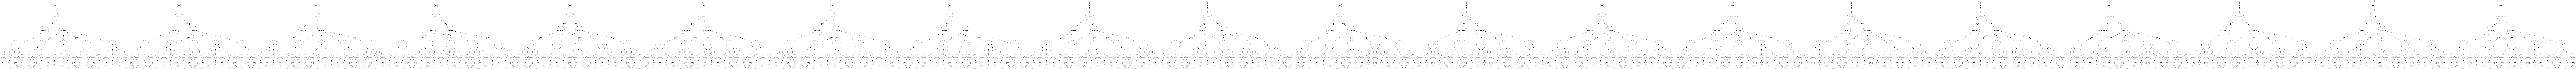

In [16]:
y.visualize()

In [17]:
%%time
y.compute()     # Time to compute the result

Wall time: 3.72 s


array([ 9.99912663, 10.00021616,  9.99876055,  9.99860397,  9.9986362 ,
        9.999718  , 10.00047804, 10.00073141,  9.99876897,  9.99996166,
        9.99992598, 10.00023917,  9.99908676, 10.00049274,  9.99957345,
       10.0013807 , 10.00021982, 10.00085153, 10.00081617,  9.99991796,
       10.00112705, 10.0003387 , 10.00001829,  9.99952667, 10.00024482,
        9.99980793,  9.9996719 ,  9.99978184, 10.00037128,  9.99983191,
       10.00039518, 10.00051862, 10.00007224, 10.00028193,  9.99863037,
       10.0002919 ,  9.99908533,  9.99993994, 10.00012512,  9.9996802 ,
       10.00052546,  9.99966169,  9.99970527, 10.00183895, 10.00092701,
        9.9987952 ,  9.99821306,  9.99993572,  9.99989067, 10.00059535,
       10.00120595, 10.00031065,  9.99883962, 10.00055108,  9.99924611,
       10.00171172,  9.99937714,  9.99918962,  9.99984085,  9.99996354,
        9.99884746, 10.00044014,  9.99985425, 10.00041513, 10.00039386,
        9.99983607, 10.00013474, 10.00089327, 10.00015875,  9.99

In [18]:
%%time 
x = np.random.normal(10, 0.1, size=(20000, 20000)) 
y = x.mean(axis=0)[::100] 

Wall time: 12.4 s


In [19]:
del x, y

### Плохо распараллеливающийся алгоритм

In [20]:
# Dask
A = da.random.random((6000, 6000), chunks=(2000,2000))
b = da.random.random((6000,), chunks=(2000,))
A, b

(dask.array<random_sample, shape=(6000, 6000), dtype=float64, chunksize=(2000, 2000)>,
 dask.array<random_sample, shape=(6000,), dtype=float64, chunksize=(2000,)>)

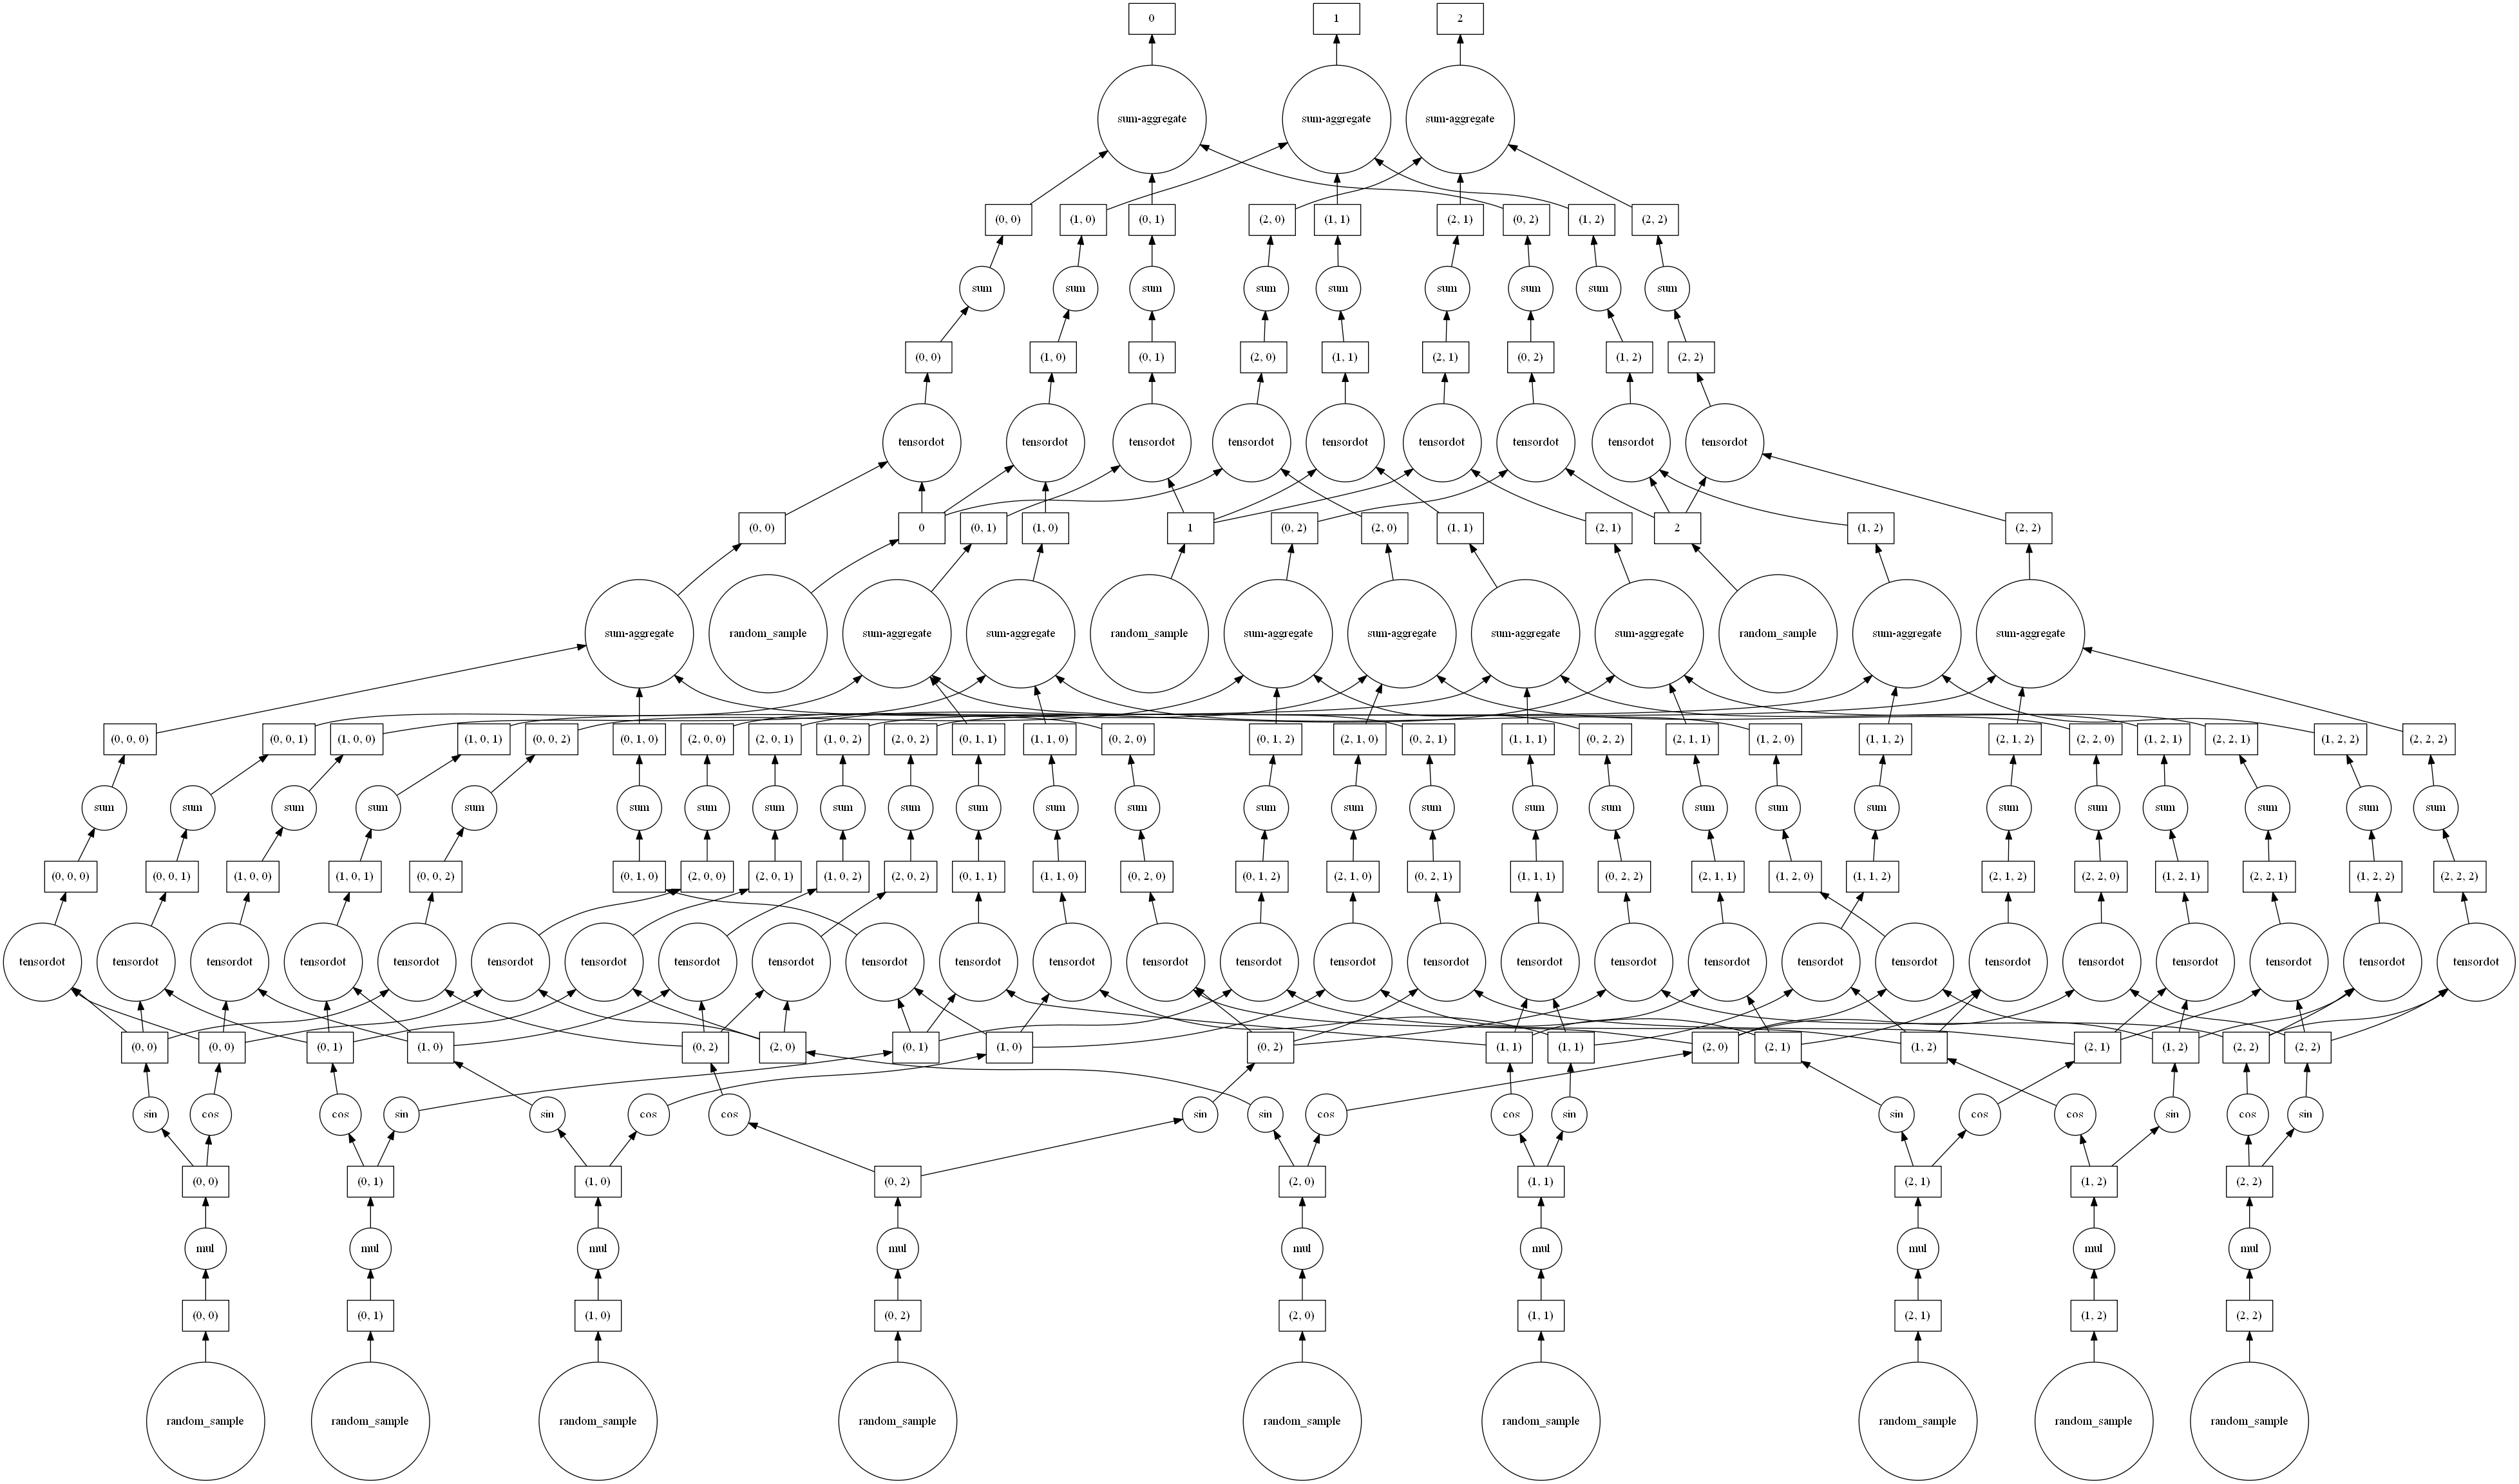

In [21]:
B = da.sin(A*A).dot(da.cos(A*A)).dot(b)
B.visualize()

In [22]:
%%timeit
B.compute()

5.64 s ± 490 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
# Numpy
A = np.random.random((6000, 6000))
b = np.random.random((6000,))
A, b

(array([[0.61589168, 0.56330167, 0.11180767, ..., 0.88657951, 0.99293155,
         0.00107933],
        [0.7200557 , 0.25021594, 0.42916734, ..., 0.33501479, 0.53924184,
         0.52337857],
        [0.0311715 , 0.20768557, 0.47361717, ..., 0.77325171, 0.05424108,
         0.17250697],
        ...,
        [0.29609839, 0.41241071, 0.89505071, ..., 0.13471929, 0.00685652,
         0.26197117],
        [0.79521189, 0.66467394, 0.96326549, ..., 0.59043922, 0.42905633,
         0.16279356],
        [0.07141565, 0.34200587, 0.35613788, ..., 0.67206107, 0.71072195,
         0.54295239]]),
 array([0.03087655, 0.25448603, 0.11610692, ..., 0.17045011, 0.33704908,
        0.42491313]))

In [24]:
%%timeit
B = np.sin(A*A).dot(np.cos(A*A)).dot(b)

5.44 s ± 370 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Вопросы и дополнения к лекции


[Snakeviz](https://jiffyclub.github.io/snakeviz/#starting-snakeviz)

[Numba](http://numba.pydata.org)

[Быстрый тест производительности Python для вычислительных задач](https://habr.com/post/336684/)

[Dask](https://github.com/dask/dask-tutorial)

[CuPy](https://github.com/cupy/cupy)